# Plot offline Eratio phase spaces:

This notebook is dedicated to plot the et/eta comp plots for offline eratio for
signal and background using mc15 (Zee and JF17).

In [1]:
from ProfileTools import profiles
from Gaugi import load
from Gaugi.monet.utils import getColor,getColors
from Gaugi.monet.PlotFunctions import *
from Gaugi.monet.TAxisFunctions import *
from Gaugi.monet.AtlasStyle import *
from ROOT import TCanvas, TH1F, TH1I
from ROOT import kRed, kBlue, kBlack,TLine,kBird, kOrange,kGray, kYellow, kViolet, kGreen, kAzure
from pprint import pprint
import array
import numpy as np
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
SetAtlasStyle()
GeV=1000.

Welcome to JupyROOT 6.23/01
Using all sub packages with ROOT dependence

Applying ATLAS style settings...


In [2]:
path = '/Volumes/castor/cern_data/files/Zee/mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17/'
path+= 'mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17_et{ET}_eta{ETA}.npz'
paths = [[ path.format(ET=et,ETA=eta) for eta in range(5)] for et in range(5)] 

In [3]:
def merge_data( paths ):
    data = None
    features = None
    target = None
    for et in range(5):
        for eta in range(5):
            raw = load(paths[et][eta])
            if data is None:
                data = raw['data']
                target = raw['target']
                features = raw['features']
            else:
                data = np.concatenate((data, raw['data']),axis=0)
                target = np.concatenate((target, raw['target']),axis=0)
    return data, target, features

data,target,_features = merge_data(paths)
features = _features.tolist()

In [4]:
def rebin_and_get_values( _data, _target, _features, _etbins, _etabins,
                          _target_value, _variables ):
    
    et = data[:, features.index('et')]
    eta = data[:, features.index('eta')]
    has_track = data[:, features.index('hastrack')]
    values = {}

    for et_bin in range(len(_etbins)-1):
        
        
        for eta_bin in range(len(_etabins)-1):
            et_low = _etbins[et_bin]
            et_upper = _etbins[et_bin+1]
            eta_low = _etabins[eta_bin]
            eta_upper = _etabins[eta_bin+1]
        
            index = np.where((target==_target_value) & (et>=et_low*GeV) \
                             & (et<et_upper*GeV) & (abs(eta) >= eta_low) \
                             & (abs(eta) < eta_upper))
            
            for key in _variables:
                name = key+'_et%d_eta%d'%(et_bin,eta_bin)
                values[name] = _data[index, features.index(key)].flatten()
    return values 

In [5]:
off_etbins = [15,20,30,40,50000]
off_etabins = [0.00,0.60,0.80,1.15,1.37,1.52,1.81,2.01,2.37,2.47]
values_sgn = rebin_and_get_values(data,target,features,off_etbins,off_etabins,1,['eratio','reta','rhad'])
values_bkg = rebin_and_get_values(data,target,features,off_etbins,off_etabins,0,['eratio','reta','rhad'])

## Let's make some plots:

In [6]:
def AddLegend(canvas, x, y, legends):
    MakeLegend( canvas,x,y,x+0.98,y+0.35,textsize=16, names=legends, option = 'p' )

In [7]:
def NormHist(hist, norm=None, removeZeros=0):
    from ROOT import TH1F
    if not norm:  norm = 1./sum(hist)
    h = TH1F(hist.GetName()+"_normalized", hist.GetTitle(), hist.GetNbinsX(), hist.GetBinLowEdge(1),
           hist.GetBinLowEdge( hist.GetNbinsX() + 1 ) )
    for bin in range(0,h.GetNbinsX()+1):
        content = hist.GetBinContent(bin)
        if not content and removeZeros:  content=removeZeros
        value = content*norm if norm else content
        h.SetBinContent(bin , value )
    return h

In [8]:
eta_leg = ['0.0 < |#eta| < 0.6',
           '0.6 < |#eta| < 0.8',
           '0.8 < |#eta| < 1.15',
           '1.15 < |#eta| < 1.37',
           '1.37 < |#eta| < 1.52',
           '1.52 < |#eta| < 1.81',
           '1.81 < |#eta| < 2.01',
           '2.01 < |#eta| < 2.37',
           '2.37 < |#eta| < 2.45',
          ]

et_leg = ['15 < E_{T} [GeV] < 20',
          '20 < E_{T} [GeV] < 30',
          '30 < E_{T} [GeV] < 40',
          'E_{T} [GeV] > 50',
         ]

In [9]:
def PlotHist( values_list, colors, markers, xlabel, bins, xmin, xmax , \
              y_axis_maximum=None, normalize=True): 
    
    def CreateHist(values, name, bins, xmin, xmax):
        h = TH1F(name, "", bins, xmin, xmax)
        w = array.array( 'd', np.ones_like(values) )
        h.FillN( len(values), array.array('d',  values.tolist()),  w)
        return h

    canvas = TCanvas('canvas','canvas',700, 500)
    col = []
    for idx, values in enumerate(values_list):
        h = CreateHist(values, 'hist_%d'%idx, bins, xmin, xmax)
        if normalize:
            h = NormHist(h)
        h.SetMarkerColor(colors[idx])
        if y_axis_maximum:
            h.SetMaximum(y_axis_maximum)  
        col.append(h)
        AddHistogram(canvas,h, 'p',markerStyle=markers[idx])
        
    FormatCanvasAxes(canvas, XLabelSize=16, YLabelSize=16, XTitleOffset=0.87, ZLabelSize=16,
                             ZTitleSize=16, YTitleOffset=1.10, ZTitleOffset=1.1)
    SetAxisLabels(canvas,xlabel, 'counts/bin (norm by counts)')
    return canvas

In [10]:
baseColor_black = np.array([10,10,10],dtype=np.float_)/255 
baseColor_red = np.array([255,10,10],dtype=np.float_)/255 
baseColor_blue = np.array([124,124,255],dtype=np.float_)/255

def getColors(outColors, transparency=None):
    from ROOT import TColor
    colors = [TColor.GetColor(r, g, b) for r, g, b in zip(*outColors)]
    if transparency:
        colors = [ TColor.GetColorTransparent( color, transparency ) for color in colors]
    return colors

def colorGradient(color1, color2, nSteps, smoothThres=None, transparency=None):
    import numpy as np
    color1 = np.array(color1)
    color2 = np.array(color2)
    deltas = color2 - color1
    deltaSum = sum(abs(deltas))
    if smoothThres is not None and deltaSum/nSteps>smoothThres:
        color2 = color1 + deltas*smoothThres*nSteps/deltaSum
    outColors = [np.linspace(pcolor1,pcolor2,nSteps) for pcolor1, pcolor2 in zip(color1,color2)]
    outColors = getColors(outColors, transparency=transparency)
    return outColors

def fadeToBlack(color1, nSteps=None, smoothThres=None, transparency=None):
    if nSteps is None: 
        smoothThres = 0.4; nSteps = 1
    return colorGradient(color1,[0,0,0], nSteps, smoothThres,transparency)

def fadeToWhite(color1, nSteps, smoothThres=None, transparency=None ):
    if nSteps is None: 
        smoothThres = 0.4; nSteps = 1
    return colorGradient(color1,[1,1,1], nSteps, smoothThres, transparency)

### Eratio:

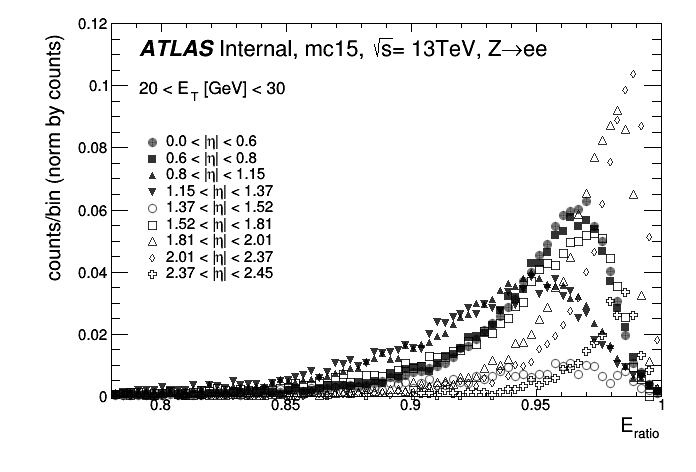

In [52]:
bins = list(range(9))
markers = list(range(20, 20+len(bins)))
eratio_list = [ values_sgn['eratio_et1_eta%d'%(etaidx)] for etaidx in bins ] 
colors = fadeToBlack(baseColor_black, len(bins), transparency=0.8)
canvas = PlotHist( eratio_list, colors, markers, 'E_{ratio}', 70, 0.78, 1.0 , \
                   y_axis_maximum=0.12, normalize=True)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV, Z#rightarrowee')
AddTexLabel(canvas, 0.2, 0.8, et_leg[1], textsize=0.04)
AddLegend( canvas,0.2,0.4, eta_leg)
canvas.Draw()
canvas.SaveAs('sgn_eratio_etaComp.pdf')

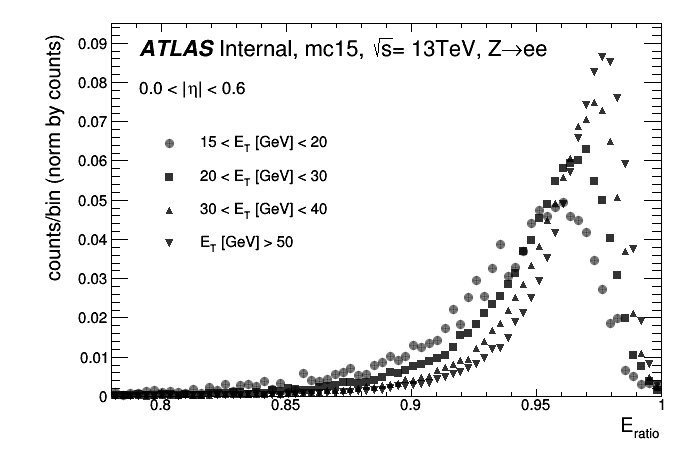

In [39]:
bins = list(range(4))
markers = list(range(20, 20+len(bins)))
eratio_list = [ values_sgn['eratio_et%d_eta0'%(etaidx)] for etaidx in bins ] 
colors = fadeToBlack(baseColor_black, len(bins),transparency=0.8)
canvas = PlotHist( eratio_list, colors, markers, 'E_{ratio}', 70, 0.78, 1 , \
              y_axis_maximum=0.095, normalize=True)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV, Z#rightarrowee')
AddTexLabel(canvas, 0.2, 0.8, eta_leg[0], textsize=0.04)
AddLegend( canvas,0.2,0.45, et_leg)
canvas.Draw()
canvas.SaveAs('sgn_eratio_etComp.pdf')

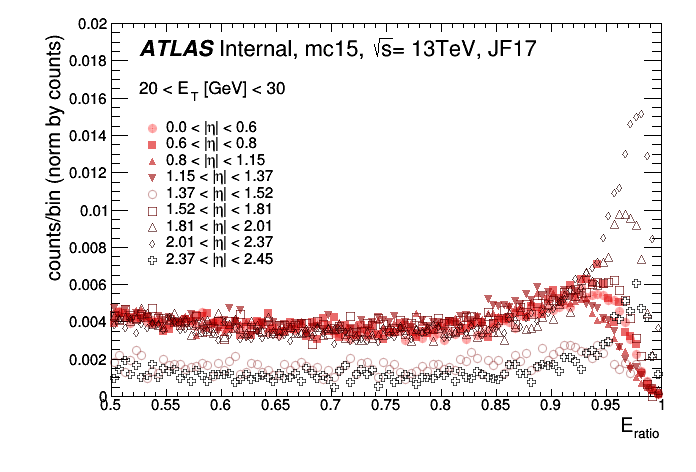

In [46]:
bins = list(range(9))
markers = list(range(20, 20+len(bins)))
eratio_list = [ values_bkg['eratio_et1_eta%d'%(etaidx)] for etaidx in bins ] 
colors = fadeToBlack(baseColor_red, len(bins),transparency=0.6)
canvas = PlotHist( eratio_list, colors, markers, 'E_{ratio}', 100, 0.5, 1 , \
                   y_axis_maximum=0.02, normalize=True)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV, JF17')
AddTexLabel(canvas, 0.2, 0.8, et_leg[1], textsize=0.04)
AddLegend( canvas,0.2,0.43, eta_leg)
#canvas.SetLogy()
canvas.Draw()
canvas.SaveAs('bkg_eratio_etaComp.pdf')

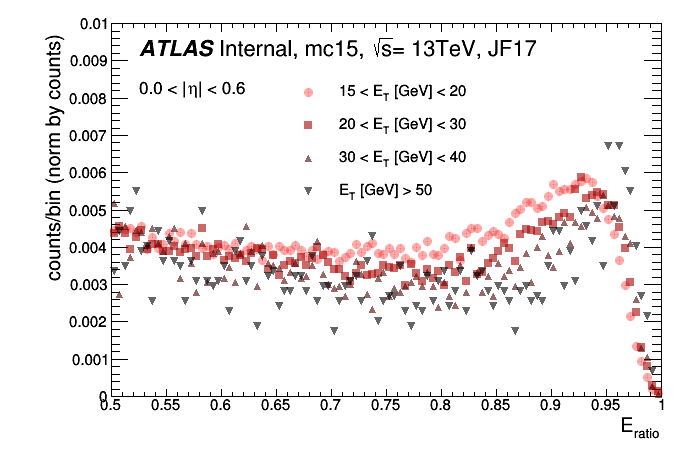

In [51]:
bins = list(range(4))
markers = list(range(20, 20+len(bins)))
eratio_list = [ values_bkg['eratio_et%d_eta0'%(etaidx)] for etaidx in bins ] 
colors = fadeToBlack(baseColor_red, len(bins), transparency=0.6)
canvas = PlotHist( eratio_list, colors, markers, 'E_{ratio}', 100, 0.5, 1 , \
              y_axis_maximum=0.01, normalize=True)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV, JF17')
AddTexLabel(canvas, 0.2, 0.8, eta_leg[0], textsize=0.04)
AddLegend( canvas,0.4,0.56, et_leg)
canvas.Draw()
canvas.SaveAs('bkg_eratio_etComp.pdf')

### Reta:

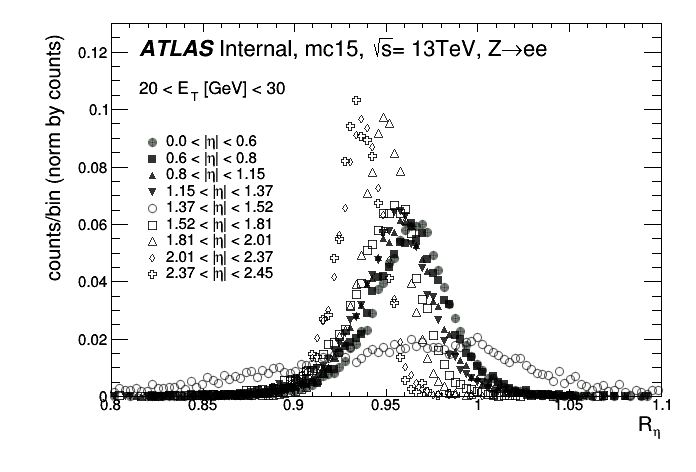

In [112]:
varname = 'reta'
bins = list(range(9))
markers = list(range(20, 20+len(bins)))
values_list = [ values_sgn[varname+'_et1_eta%d'%(etaidx)] for etaidx in bins ] 
colors = fadeToBlack(baseColor_black, len(bins), transparency=0.8)
canvas = PlotHist( values_list, colors, markers, 'R_{#eta}', 100, 0.8, 1.1 , \
                   y_axis_maximum=0.13, normalize=True)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV, Z#rightarrowee')
AddTexLabel(canvas, 0.2, 0.8, et_leg[1], textsize=0.04)
AddLegend( canvas,0.2,0.4, eta_leg)
canvas.Draw()
canvas.SaveAs('sgn_%s_etaComp.pdf'%varname)

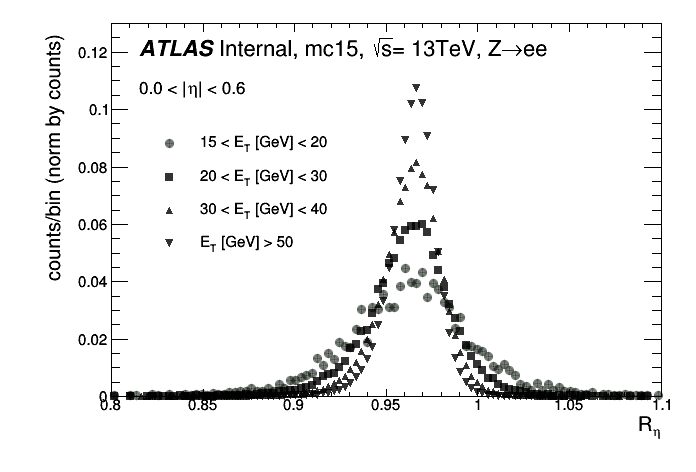

In [113]:
varname = 'reta'
bins = list(range(4))
markers = list(range(20, 20+len(bins)))
values_list = [ values_sgn[varname+'_et%d_eta0'%(etaidx)] for etaidx in bins ] 
colors = fadeToBlack(baseColor_black, len(bins),transparency=0.8)
canvas = PlotHist( values_list, colors, markers, 'R_{#eta}', 100, 0.8, 1.1 , \
              y_axis_maximum=0.13, normalize=True)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV, Z#rightarrowee')
AddTexLabel(canvas, 0.2, 0.8, eta_leg[0], textsize=0.04)
AddLegend( canvas,0.2,0.45, et_leg)
canvas.Draw()
canvas.SaveAs('sgn_%s_etComp.pdf'%varname)

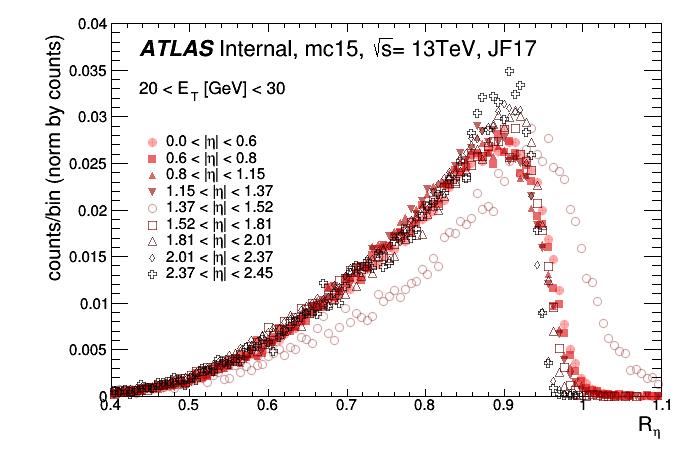

In [114]:
varname = 'reta'
bins = list(range(9))
markers = list(range(20, 20+len(bins)))
values_list = [ values_bkg[varname+'_et1_eta%d'%(etaidx)] for etaidx in bins ] 
colors = fadeToBlack(baseColor_red, len(bins),transparency=0.6)
canvas = PlotHist( values_list, colors, markers, 'R_{#eta}', 100, 0.4, 1.1 , \
                   y_axis_maximum=0.04, normalize=True)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV, JF17')
AddTexLabel(canvas, 0.2, 0.8, et_leg[1], textsize=0.04)
AddLegend( canvas,0.2,0.4, eta_leg)
#canvas.SetLogy()
canvas.Draw()
canvas.SaveAs('bkg_%s_etaComp.pdf'%varname)

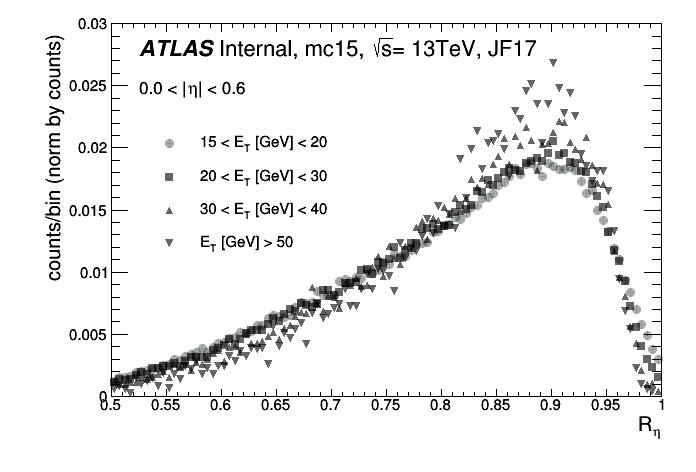

In [115]:
varname = 'reta'
bins = list(range(4))
markers = list(range(20, 20+len(bins)))
values_list = [ values_bkg[varname+'_et%d_eta0'%(etaidx)] for etaidx in bins ] 
colors = fadeToBlack(baseColor_black, len(bins), transparency=0.6)
canvas = PlotHist( values_list, colors, markers, 'R_{#eta}', 100, 0.5, 1 , \
              y_axis_maximum=0.03, normalize=True)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV, JF17')
AddTexLabel(canvas, 0.2, 0.8, eta_leg[0], textsize=0.04)
AddLegend( canvas,0.2,0.45, et_leg)
canvas.Draw()
canvas.SaveAs('bkg_%s_etComp.pdf'%varname)